In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

import os
from os.path import join
import glob
import random

plt.ion()   # interactive mode

In [9]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [3]:
bce = nn.BCEWithLogitsLoss()

In [2]:
data_path = "/home/rohit/Documents/Job_Search/face-classification/data"
img_dir = join(data_path, "lfw-deepfunneled")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def parse_pairs(f_name):
    with open(f_name) as f:
        num_sets, num_pairs = [int(p) for p in f.readline().strip().split()]
        subsets = []
        for i in range(num_sets):
            subset = {'match': [f.readline().strip().split() for i in range(num_pairs)],
                      'mismatch': [f.readline().strip().split() for i in range(num_pairs)]}
            subsets.append(subset)
            
    return subsets

In [4]:
def get_image(name, img_id):
    img_name = '0'*(4-len(img_id)) + img_id
    
    return io.imread(join(img_dir, name, f'{name}_{img_name}.jpg'))

In [5]:
def create_dataset(names):
    dataset = []
    
    for i, name_subset in enumerate(names):
        print(f"Loading subset : {i + 1}")
        img_subset = {'match': [],
                      'mismatch': []}
        
        match_names = name_subset['match']
        for pair in match_names:
            name, img_id1, img_id2 = pair
            img1 = get_image(name, img_id1)
            img2 = get_image(name, img_id2)
            img_subset['match'].append([img1, img2])
            
        mismatch_names = name_subset['mismatch']
        for pair in mismatch_names:
            name1, img_id1, name2, img_id2 = pair
            img1 = get_image(name1, img_id1)
            img2 = get_image(name2, img_id2)
            img_subset['mismatch'].append([img1, img2])
            
        dataset.append(img_subset)
        
    return dataset

In [6]:
cross_sets_names = parse_pairs(join(data_path, 'pairs.txt'))
cross_sets_dataset = create_dataset(cross_sets_names)

Loading subset : 1
Loading subset : 2
Loading subset : 3
Loading subset : 4
Loading subset : 5
Loading subset : 6
Loading subset : 7
Loading subset : 8
Loading subset : 9
Loading subset : 10


In [7]:
def visualize_dataset(dataset, n=5):
    """
    First two columns plot n random matching faces, and the next two plot random mismatching faces.
    """
    subset_id = random.randint(0, 9)
    subset = dataset[subset_id]
    
    match_pair_ids = random.sample(list(range(len(subset['match']))), n)
    mismatch_pair_ids = random.sample(list(range(len(subset['mismatch']))), n)
    
    plt.figure(figsize=(20,10))
    
    plt.subplot(n, 1, 1)
    for i, pair_id in enumerate(match_pair_ids):
        plt.subplot(n, 4, i * 4 + 1)
        plt.imshow(subset['match'][pair_id][0])
        
        plt.subplot(n, 4, i * 4 + 2)
        plt.imshow(subset['match'][pair_id][1])
        
    for i, pair_id in enumerate(mismatch_pair_ids):
        plt.subplot(n, 4, i * 4 + 3)
        plt.imshow(subset['mismatch'][pair_id][0])
        
        plt.subplot(n, 4, i * 4 + 4)
        plt.imshow(subset['mismatch'][pair_id][1])

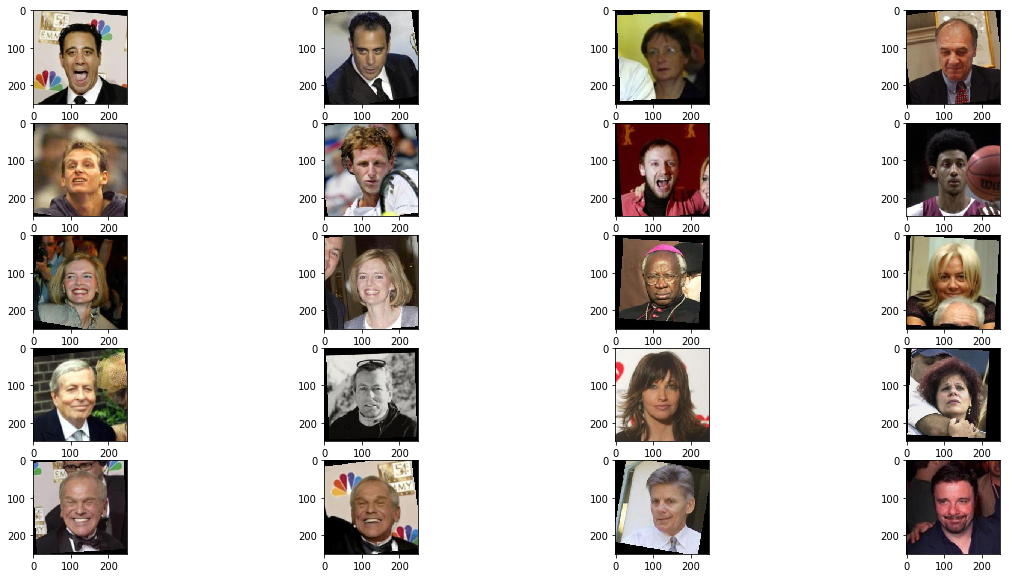

In [8]:
visualize_dataset(cross_sets_dataset)

## Dataset

In [9]:
class FaceDataset(Dataset):
    """Face Classification dataset."""

    def __init__(self, full_dataset, include_subsets, transform=None):
        """
        Args:
            full_dataset (list of dict): Full cross validation dataset.
            include_subsets (list): Subsets to be included in dataloader.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = self._process_dataset(full_dataset, include_subsets)
        self.transform = transform
        
    @staticmethod
    def _process_dataset(full_dataset, include_subsets):
        ret = []
        subsets = [full_dataset[subset_id] for subset_id in include_subsets]
        for subset in subsets:
            for img1, img2 in subset['match']:
                ret.append([img1, img2, 1])
            for img1, img2 in subset['mismatch']:
                ret.append([img1, img2, 0])
        
        return ret

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img1, img2, label = self.dataset[idx]
            
        sample = {'img1': img1, 'img2': img2, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
def plot_sample(sample):    
    img1, img2 = sample['img1'], sample['img2']

    plt.subplot(1, 2, 1)
    plt.imshow(img1.transpose((1 ,2, 0)))
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2.transpose((1 ,2, 0)))   
    
    label = sample['label']
    if label:
        plt.suptitle('MATCH')
    else:
        plt.suptitle('MISMATCH')

## Transforms

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        img1, img2, label = sample['img1'], sample['img2'], sample['label']

        def transform_img(image):
            h, w = image.shape[:2]
            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)
            img = transform.resize(image, (new_h, new_w))
            
            return img
        
        img1 = transform_img(img1)
        img2 = transform_img(img2)

        return {'img1': img1, 'img2': img2, 'label': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        img1, img2, label = sample['img1'], sample['img2'], sample['label']

        def transform_img(image):
            h, w = image.shape[:2]
            new_h, new_w = self.output_size

            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h,
                          left: left + new_w]
            
            return image

        img1 = transform_img(img1)
        img2 = transform_img(img2)

        return {'img1': img1, 'img2': img2, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        img1, img2, label = sample['img1'], sample['img2'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img1 = img1.transpose((2, 0, 1))
        img2 = img2.transpose((2, 0, 1))

        return {'img1': img1, 'img2': img2, 'label': label}

In [12]:
dataset = FaceDataset(cross_sets_dataset, 
                      [1,2],
                      transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()])
                     )
len(dataset)

1200

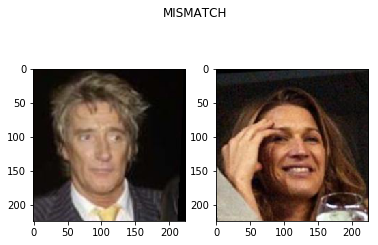

In [13]:
plot_sample(dataset[random.randint(0, len(dataset))])

## Model

In [14]:
class PairFaceClassifier(nn.Module):
    
    """Classfies if two images belong to same person.
    
        Base model: CNN model that extracts features of the images.
    """
    def __init__(self, base_model='resnet18', hidden_ftrs=128):
        super(PairFaceClassifier, self).__init__()
        if base_model == 'resnet18':
            self.model_conv = torchvision.models.resnet18(pretrained=True)
        elif base_model == 'alexnet':
            self.model_conv = torchvision.models.alexnet(pretrained=True)

            
        num_ftrs = self.model_conv.fc.in_features
        self.model_conv.fc = nn.Linear(num_ftrs, hidden_ftrs)
        
        self.fc = nn.Linear(2 * hidden_ftrs, 1)
        
    def forward(self, input):
        img1, img2 = input
        
        out1 = self.model_conv(img1)
        out2 = self.model_conv(img2)
        
        score = self.fc(torch.cat(out1, out2))
        
        return score

In [18]:
model = PairFaceClassifier().double()

In [19]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [ ]:
for batch in dataloader:
    img1, img2, label = batch['img1'], batch['img2'], batch['label']
    score = model((img1, img2))
    print(label, score)